### Capstone 1: White Wine Quality, UC Irvine
(Source: Paulo Cortez (Univ. Minho), Antonio Cerdeira, Fernando Almeida, Telmo Matos and Jose Reis (CVRVV) @ 2009)

# 5. Random Forest Classifer - Three Classes

#### Audrey Hughes Rager
#### January 26, 2021



## Import Python Packages

In [95]:
#Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import datetime as dt
import statsmodels.api as sm
from scipy.stats import norm
import statsmodels.stats.weightstats as smsw

import pylab

# Import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
#from sklearn import cross_validation
from scipy import stats as st
import warnings 
warnings.filterwarnings('ignore')
# Import Classification Report and Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
# Import StandardScalar and LabelEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
# Import precision_recall_curve
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
# Import average_precision_score
from sklearn.metrics import average_precision_score

# Import pyplot from matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('whitegrid')


<h2>Data Wrangling</h2>

In [96]:
#Import csv files into Pandas data frames
#reddf = pd.read_csv('winequality-red.csv',sep=";")
whitedf = pd.read_csv('winequality-white.csv',sep=";")
df = pd.read_csv('winequality-white.csv',sep=";")
df = df.rename({'fixed acidity': 'fixed_acidity','volatile acidity': 'volatile_acidity', 'citric acid': 'citric_acid', 'residual sugar':'residual_sugar',  'free sulfur dioxide':'free_sulfur_dioxide', 'total sulfur dioxide':'total_sulfur_dioxide'}, axis=1)
print("Dataset Shape: ", df.shape)



Dataset Shape:  (4898, 12)


In [97]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [98]:
df['quality'].value_counts

<bound method IndexOpsMixin.value_counts of 0       6
1       6
2       6
3       6
4       6
       ..
4893    6
4894    5
4895    6
4896    7
4897    6
Name: quality, Length: 4898, dtype: int64>

In [99]:
df["quality"].unique()

array([6, 5, 7, 8, 4, 3, 9])

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64


<AxesSubplot:xlabel='quality', ylabel='count'>

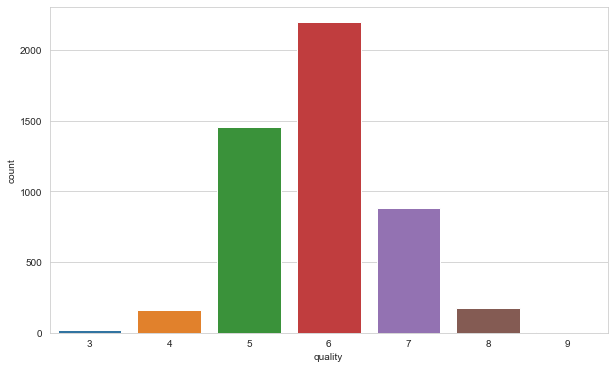

In [100]:
print(df['quality'].value_counts())

fig = plt.figure(figsize = (10,6))
sns.countplot(df['quality'])

## Reclassify

In [101]:
#Values of 3, 4, and 5 reassigned to "inferior" rating
#Value of 6 reassigned to "fine" rating
#Values of 7, 8, and 9 reassigned to "superior" rating
conditions = [
    (df['quality'] >= 7),
    (df['quality'] <= 5)
]

rating = ['superior', 'inferior']
df['rating'] = np.select(conditions, rating, default='fine')
df.rating.value_counts()

fine        2198
inferior    1640
superior    1060
Name: rating, dtype: int64

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         4898 non-null   float64
 1   volatile_acidity      4898 non-null   float64
 2   citric_acid           4898 non-null   float64
 3   residual_sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free_sulfur_dioxide   4898 non-null   float64
 6   total_sulfur_dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
 12  rating                4898 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 497.6+ KB


In [103]:
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,rating
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,fine
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,fine
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,fine
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,fine
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,fine


In [104]:
df["rating"].unique()

array(['fine', 'inferior', 'superior'], dtype=object)

fine        2198
inferior    1640
superior    1060
Name: rating, dtype: int64


<AxesSubplot:xlabel='rating', ylabel='count'>

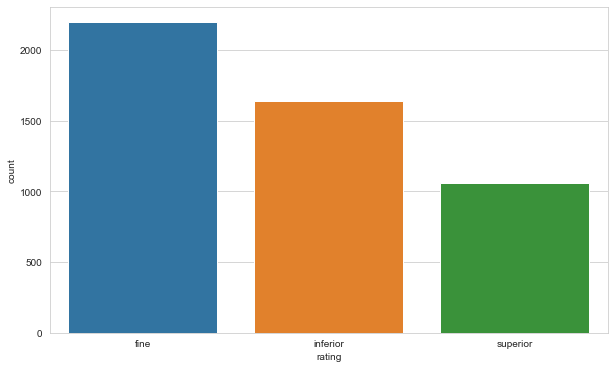

In [105]:
print(df['rating'].value_counts())

fig = plt.figure(figsize = (10,6))
sns.countplot(df['rating'])

In [106]:
label_quality = LabelEncoder()
df["rating"] = label_quality.fit_transform(df["rating"])


Wine Rating


<AxesSubplot:xlabel='rating', ylabel='count'>

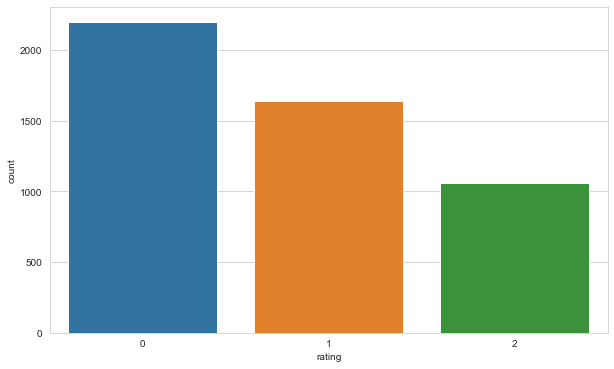

In [107]:
#Histogram of Wine Rating
print('Wine Rating')
fig = plt.figure(figsize = (10,6))
sns.countplot(x='rating', data=df)

## Train Test Split

In [108]:
X = df.drop(['quality','rating'],axis=1)
y = df['rating']

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)


## Random Forests


In [117]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [118]:
rfc_pred = rfc.predict(X_test)
y_score = rfc_pred

In [119]:
print(confusion_matrix(y_test,rfc_pred))

[[518 103  59]
 [124 345   8]
 [122   8 183]]


In [120]:
print(classification_report(y_test,rfc_pred))
print("0 = Fine")
print("1 = Inferior")
print("2 = Superior")

              precision    recall  f1-score   support

           0       0.68      0.76      0.72       680
           1       0.76      0.72      0.74       477
           2       0.73      0.58      0.65       313

    accuracy                           0.71      1470
   macro avg       0.72      0.69      0.70      1470
weighted avg       0.72      0.71      0.71      1470

0 = Fine
1 = Inferior
2 = Superior


## Multi-class Precision-Recall

In [121]:
type(y_test)

numpy.ndarray

In [122]:
type(y_score)

numpy.ndarray

#### The average precision score in multi-label settings

In [124]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

n_classes = 3
#convert y_test to numpy array because this was suggested on Stack Overflow
y_test = y_test.to_numpy()


# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))



AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

#### Plot the micro-averaged Precision-Recall curve

In [48]:
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

KeyError: 'micro'

<Figure size 432x288 with 0 Axes>

#### Plot Precision-Recall curve for each class and iso-f1 curves

In [ ]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()